<br>
# **자연어에서 딥러닝의 활용**
Machine Learning for Natural Language

<br>
## **1 데이터 임베딩과 표상학습**
임베딩 : 복잡한 원시 데이터(raw data)를 컴퓨터가 학습을 통해서 생성한(computer-generated) 축소된 숫자값의 목록
1. **tf-idf** : 벡터화에 바탕을 둔 **용어빈도 - 역 문서 빈도** 를 활용
1. **PCA** : 차원의 저주를 극복하기 위해 **기본 데이터를 압축**하는 방법으로써 활용
1. **One-hot Encoding** : 개별 Factor 간의 구별은 가능하지만, 의미적 유사도를 알기는 어렵다
1. **Word2Vec** : Mikolov가 고안한 방법으로 "주변 단어를 보면 그 단어를 알 수 있다" (John Firth)

<br>
## **2 Word 2 Vector** <small>https://ronxin.github.io/wevi/</small>
**단어의 분포**를 **고밀도 vector**로 표현하고, **단어간의 유사도**는 **Cosin 측정방법(벡터의 내적)**으로 수치화 한다

1. 2013년 구글에서 개발한 기법
1. **Skip Gram** : 사용자가 원하는 target 데이터를 추측하고, 이를 기초로 문맥의 요소들을 예측한다
1. **Continuous Bag of Word** : 전체 문맥의 어휘들로 요소를 만들고, 목표인 Target을 예측하기 위해 모델을 생성한다

<img src="https://www.lucypark.kr/docs/2015-pyconkr/w2v.png" align='left' width='600'>

<br>
### **CBOW (Continuous Bag-of-Words 모델)**
1. **원하는 대상 주변**의 token을 대상으로 모델을 생성
1. 문장의 **여러 단어들 가운데**, 빈 단어를 채운다
1. 주어진 단어 앞뒤로 여유분의 token을 선택하고
1. 이들을 활용하여 적합한 내용을 유추하는 Network를 생성한다

<br>
### **skip-gram 모델**
1. **주어진 token**을 갖고서 **주위의 단어들을 유추**한다
1. **단어간의 빈도**를 활용하여가까운 단어일수록 가깝고, 먼 단어일수록 빈도가 낮음을 활용한다
1. 위의 CBOW와 같은 모델연산을 요하지만
1. **샘플링 기준이 되는 단어를 몇개**로 정하는지에 따라 연산시간이 많이 차이난다 (다양한 기법들을 활용가능)
1. 실무에서는 CBOW 보단 **skip-gram**이 더 좋은 결과를 보여준다

<br>
### **Tensorflow 를 활용한 Word2Vec**
텐서플로를 활용하여 Skip-Gram 기법을 활용하여 Word2Vec 만들기

In [1]:
# 독일 퀘르버 재단 연설문 : 베를린 선언
# 문서 불러오기
f     = open('./data/베를린선언.txt', 'r')
texts_Berlin_raw = f.read()
f.close()
texts_Berlin = texts_Berlin_raw.split('\n\n')

In [2]:
# Stop Word 전처리
import string
punct = string.punctuation
punct = [punct[i] for i in range(len(punct))]
punct = punct + ['\n', ')', '(']

# 불필요한 기호들을 제거한다
for dump in punct: 
    texts_Berlin = [txt.replace(dump, '')    for txt in texts_Berlin]
print(len(texts_Berlin))

309


In [3]:
# word_sequence : 단어 배열 원본 
# word_list     : 단어 배열 중복제거
# word_dict     : word_list의 인덱스 배열을 생성 

word_sequence = " ".join(texts_Berlin).split()
word_list     = " ".join(texts_Berlin).split()
word_list     = list(set(word_list))
word_dict     = {w: i for i, w in enumerate(word_list)}

In [4]:
# Word2Vec 모델을 간단하게 구현해봅니다.
import tensorflow as tf
import numpy as np

# skip-gram을 만든 후, 고유 번호(index)를 저장
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target  = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i-1]], word_dict[word_sequence[i+1]]]
    for w in context:
        skip_grams.append([target, w])

In [5]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성
def random_batch(data, size):
    random_inputs, random_labels = [], []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    for i in random_index:
        random_inputs.append(data[i][0])    # target
        random_labels.append([data[i][1]])  # context word
    return random_inputs, random_labels

In [6]:
training_epoch = 300
learning_rate  = 0.1
batch_size     = 20
embedding_size = 2   # 단어벡터 임베딩 차원 (x, y 2개만 출력)
num_sampled    = 15  # 모델의 nce_loss 샘플크기 (batch_size 보다 작아야 한다)
voc_size       = len(word_list) # 총 단어 갯수

In [7]:
inputs = tf.placeholder(tf.int32, shape=[batch_size])
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과를 저장할 임베딩 벡터를 정의
embeddings     = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases  = tf.Variable(tf.zeros([voc_size]))

# nce_loss 함수는 tf.nn.nce_loss 함수를 사용
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [8]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)
        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})
        if step % 30 == 0:
            print("loss at step ", step, ": ", loss_val)
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()

loss at step  30 :  42.672424
loss at step  60 :  36.3151
loss at step  90 :  42.631104
loss at step  120 :  28.415817
loss at step  150 :  37.543827
loss at step  180 :  21.100582
loss at step  210 :  46.856636
loss at step  240 :  20.035889
loss at step  270 :  5.320979
loss at step  300 :  25.137186


In [9]:
%matplotlib inline
from matplotlib import font_manager, rc
font_fname = './data/D2Coding.ttf'     
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

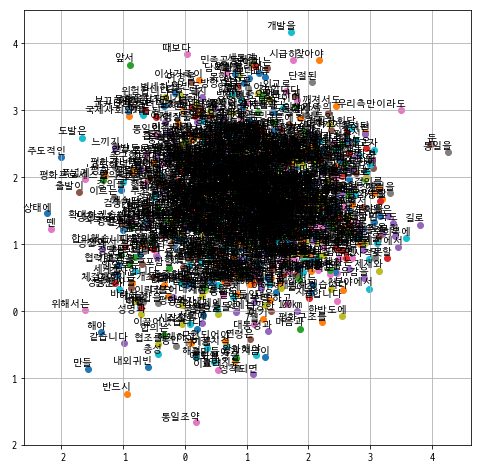

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.grid(True)
plt.show()

<br>
## **3 gensim**
1. https://radimrehurek.com/gensim/
1. Why is Gensim Word2Vec so much faster than Keras GPU? [link](https://www.reddit.com/r/learnmachinelearning/comments/88eeua/why_is_gensim_word2vec_so_much_faster_than_keras/)
1. word to Vec 모델 만들기
1. 만들어진 모델을 저장하기
1. 저장된 모델을 사용하여 단어간 유사한 그룹 출력하기


<br>
### **01 Word to Vector**
**from** gensim.models **import** Word2Vec

**Word2Vec**(tokenized_contents, size=100, window = 2, min_count=50, workers=4, iter=100, sg=1)
1. **size = 100** : 포스태깅된 컨텐츠를 100차원의 벡터로 변환. 
1. **window = 2** : 주변 단어(window)는 앞뒤로 두개를 포함
1. **min_count=50** :  코퍼스 내 출현 빈도가 50번 미만인 단어는 분석에서 제외
1. **iter=100** : CPU는 쿼드코어를 쓰고 100번 반복 학습
1. **sg=1** : 분석방법론은 CBOW와 Skip-Gram 중 **Skip-Gram**를 선택

In [11]:
%%time
# 텍스트를 한 줄씩 문법 tag를 추가한다
results, lines = [], texts_Berlin
from konlpy.tag import Twitter
twitter = Twitter()

for line in lines:
    malist = twitter.pos(line, norm=True, stem=True)
    result = [ word[0]   for word in malist    # 어미/조사/구두점 제외
               if not word[1] in ["Eomi", "Josa", "Punctuation"] ]
    rl = (" ".join(result)).strip()
    results.append(rl)
    
texts_file = './data/Berlin.tagged'
with open(texts_file, 'w', encoding='utf-8') as fp:
    fp.write("\n".join(results))

CPU times: user 5.76 s, sys: 159 ms, total: 5.92 s
Wall time: 2.08 s


In [13]:
%%time
# Word2Vec 데이터 모델을 학습한 뒤 저장한다
from gensim.models import word2vec
data  = word2vec.LineSentence(texts_file)
model = word2vec.Word2Vec(data, size=200, window=10, hs=1, min_count=2, sg=1)
model.save("./data/Berlin.model")
print("ok")

ok
CPU times: user 544 ms, sys: 41.4 ms, total: 586 ms
Wall time: 349 ms


<br>
### **02 저장된 모델을 활용하기**
gensim

In [14]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('./data/Berlin.model')

In [15]:
model.wv.most_similar(positive=['한반도'])

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.9920262098312378),
 ('있다', 0.9914730191230774),
 ('적', 0.9912476539611816),
 ('이다', 0.9885356426239014),
 ('수', 0.9882135987281799),
 ('정치', 0.9873417019844055),
 ('경제', 0.9870409369468689),
 ('평화', 0.9869157075881958),
 ('째', 0.9868207573890686),
 ('것', 0.9868068099021912)]

In [16]:
model.wv.most_similar(positive=['통일'])

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.9866442680358887),
 ('적', 0.9828549027442932),
 ('있다', 0.9819353222846985),
 ('되다', 0.9817389249801636),
 ('것', 0.9813769459724426),
 ('한반도', 0.9803606271743774),
 ('’', 0.980017900466919),
 ('정치', 0.9798284769058228),
 ('수', 0.9795560240745544),
 ('군사', 0.9795385599136353)]

In [17]:
model.wv.most_similar(positive=['정치'])

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.9901097416877747),
 ('한반도', 0.9873417019844055),
 ('군사', 0.9869926571846008),
 ('있다', 0.9869689345359802),
 ('째', 0.9868484735488892),
 ('수', 0.9863592386245728),
 ('교류', 0.9857667088508606),
 ('적', 0.9854397773742676),
 ('’', 0.9852924942970276),
 ('되다', 0.9842091202735901)]

<br>
### **03 Gensim을 활용하여 긍정/부정 분석모델 만들기**
1. 앞에서 nltk 모듈을 활용하여 
# gensim 모델의 오류수정 : http://daewonyoon.tistory.com/240
# https://github.com/hoho0443/classify_comment_emotion

In [32]:
from konlpy.tag import Kkma, Twitter

Kkma().pos("오버워치")  # [('오버', 'NNG'), ('워', 'UN'), ('하', 'XSV'), ('지', 'ECD')]
Twitter().pos("오버워치")

[('오버', 'Noun'), ('워치', 'Noun')]

In [33]:
import gensim

sentences = [["my", "name", "is", "jamie"], ["jamie", "is", "cute"]]
model = gensim.models.Word2Vec(sentences)

RuntimeError: you must first build vocabulary before training the model

In [19]:
# 리뷰 Text를 Python 객체로 불러온다
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
        
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/50)) ]
    return random_data

train_data = read_data('./data/ratings_train.txt')
test_data  = read_data('./data/ratings_test.txt')
print('Train_data : {}\nsample     : {}'.format(len(train_data), train_data[:3]))
print('Test_data  : {}\nsample     : {}'.format(len(test_data), test_data[:3]))

Train_data : 3000
sample     : [['10077443', '평점 깎기놀이ㅋㅋ ^^', '0'], ['2574127', '내용도 좋고 배우들도 연기 잘했던걸로... 근데 시청률이 ㅠㅠ', '1'], ['7534739', '나진주 행복해서 다행이다 선생님 그냥 오픈티켓 날려주시네ㅎ 그래서 2점!', '0']]
Test_data  : 1000
sample     : [['5248960', '개연성없고지루한졸작이 상을받은 웃지못할 예. 일본인은 또 징기스칸역이냐?어이상실', '0'], ['6856508', '배우들이뻐서 10점 ㅋㅋㅋ', '1'], ['4268419', '남자 조낸 찌질한 연기 잘함...보는 내가 답답해요..그동안 봐온 독립영화중 좀글네요', '0']]


In [ ]:
for line in lines:
    malist = twitter.pos(line, norm=True, stem=True)
    result = [ word[0]   for word in malist    # 어미/조사/구두점 제외
               if not word[1] in ["Eomi", "Josa", "Punctuation"] ]
    rl = (" ".join(result)).strip()
    results.append(rl)


In [20]:
%%time
from konlpy.tag import Twitter
pos_tagger = Twitter()

def tokenize(doc):
    result = ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]
    return result 

train_docs = [(tokenize(row[1]), row[2])    for row in train_data]
test_docs  = [(tokenize(row[1]), row[2])    for row in test_data]

from pprint import pprint
pprint(train_docs[:2])

[(['평점/Noun', '깎다/Verb', '놀이/Noun', 'ㅋㅋ/KoreanParticle', '^^/Punctuation'],
  '0'),
 (['내용/Noun',
   '도/Josa',
   '좋다/Adjective',
   '배우/Noun',
   '들/Suffix',
   '도/Josa',
   '연기/Noun',
   '잘하다/Verb',
   '.../Punctuation',
   '근데/Adverb',
   '시청률/Noun',
   '이/Josa',
   'ㅠㅠ/KoreanParticle'],
  '1')]
CPU times: user 7.85 s, sys: 0 ns, total: 7.85 s
Wall time: 4.41 s


In [29]:
tokens = [t   for d in train_docs 
              for t in d[0]]
tokens = [tuple(txt.split('/')) for txt in tokens]    
print(len(tokens))

43333


In [30]:
from gensim.models import doc2vec
# 사전 구축
doc_vectorizer = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(tokens)
# Train document vectors!
for epoch in range(10):
    doc_vectorizer.train(tokens)
    doc_vectorizer.alpha -= 0.002  # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha  # fix the learning rate, no decay
# To save
# doc_vectorizer.save('doc2vec.model')

AttributeError: 'tuple' object has no attribute 'words'

In [18]:
texts_tagged

NameError: name 'texts_tagged' is not defined

In [ ]:
results

In [ ]:
from gensim.models import doc2vec
# 사전 구축
doc_vectorizer = doc2vec.Doc2Vec(size=300, alpha=0.025, min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(results)
# Train document vectors!
for epoch in range(10):
    doc_vectorizer.train(texts_tagged)
    doc_vectorizer.alpha -= 0.002  # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha  # fix the learning rate, no decay
# To save
# doc_vectorizer.save('doc2vec.model')

### 02.ml_for_nltk
word2Vec
1. Gensim
1. Tensorflow
1. tSNE

LSTM 문장생성
1. HMM 은 유사도만 측정 가능하고, 그 확률이 낮아서 문장생성은 어렵다
1. LSTM도 낮은 확률에 근거하여 Text를 생성하지만, 반복 학습을 통해서 오차를 줄이는 과정을 통해 정밀성을 높일 수 있다

LSTM 챗봇실습
1. 어린왕자 Text를 대통령 연설문으로 바꿔서 챗봇 구현하기

seq2seq
1. Text 생성

Attention
1. Image Detection